In [1]:
# Importieren der notwendigen Bibliotheken
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

import statsmodels.api as sm
from statsmodels.formula.api import ols
from scipy.stats import chi2_contingency
from itertools import combinations

In [2]:
#daten einlesen
train_df_initial = pd.read_csv('train.csv')

In [3]:
#Auswahl aller kategorischen Spalten.
categorical_cols = train_df_initial.select_dtypes(include=['object']).columns

train_df_initial[categorical_cols]

,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,...,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
0,RL,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,...,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
1,RL,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,...,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
2,RL,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,...,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
3,RL,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,...,Detchd,Unf,TA,TA,Y,NaN,NaN,NaN,WD,Abnorml
4,RL,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,...,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,RL,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,...,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
1456,RL,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NWAmes,Norm,...,Attchd,Unf,TA,TA,Y,NaN,MnPrv,NaN,WD,Normal
1457,RL,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Crawfor,Norm,...,Attchd,RFn,TA,TA,Y,NaN,GdPrv,Shed,WD,Normal
1458,RL,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,...,Attchd,Unf,TA,TA,Y,NaN,NaN,NaN,WD,Normal


In [4]:
#Infos über Daten und Auswahl der Spalten, wo es zu viele Nan als 'fehlende Werte' giubt.

train_df_initial[categorical_cols].info()

missing_values_columns_cat = []

for col in train_df_initial[categorical_cols].columns:
    if train_df_initial[col].isnull().sum() > 0:
        missing_values_columns_cat.append(col)
        
missing_values_columns_cat            

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 43 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   MSZoning       1460 non-null   object
 1   Street         1460 non-null   object
 2   Alley          91 non-null     object
 3   LotShape       1460 non-null   object
 4   LandContour    1460 non-null   object
 5   Utilities      1460 non-null   object
 6   LotConfig      1460 non-null   object
 7   LandSlope      1460 non-null   object
 8   Neighborhood   1460 non-null   object
 9   Condition1     1460 non-null   object
 10  Condition2     1460 non-null   object
 11  BldgType       1460 non-null   object
 12  HouseStyle     1460 non-null   object
 13  RoofStyle      1460 non-null   object
 14  RoofMatl       1460 non-null   object
 15  Exterior1st    1460 non-null   object
 16  Exterior2nd    1460 non-null   object
 17  MasVnrType     588 non-null    object
 18  ExterQual      1460 non-null

['Alley',
 'MasVnrType',
 'BsmtQual',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinType1',
 'BsmtFinType2',
 'Electrical',
 'FireplaceQu',
 'GarageType',
 'GarageFinish',
 'GarageQual',
 'GarageCond',
 'PoolQC',
 'Fence',
 'MiscFeature']

In [5]:
#Aussortieren der Spalten, wo es viele fehlende Werte gibt und Zuzufügen der Target Spalte.

train_df_cat_rel = train_df_initial[categorical_cols].drop(missing_values_columns_cat, axis=1)

train_df_cat_rel['SalePrice'] = train_df_initial['SalePrice']

train_df_cat_rel_no_targ = train_df_cat_rel.drop('SalePrice', axis=1).reset_index(drop=True)


In [ ]:
#1. Anova Test, um die Kategorischen Spalte auszusuchen, die für eine Regression interessant sein könnten

rel_cat = []

for feature in train_df_cat_rel_no_targ.columns:
    model = ols(f'SalePrice ~ C({feature})', data=train_df_cat_rel).fit()
    table = sm.stats.anova_lm(model, typ=2)
    if table['PR(>F)'][0] < 0.05:
        rel_cat.append(feature)

rel_cat

C:\Users\Ella\AppData\Local\Temp\ipykernel_9304\3755480437.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if table['PR(>F)'][0] < 0.05:
C:\Users\Ella\AppData\Local\Temp\ipykernel_9304\3755480437.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if table['PR(>F)'][0] < 0.05:
C:\Users\Ella\AppData\Local\Temp\ipykernel_9304\3755480437.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if table['PR(>F)'][0] < 0.05:
C:\Users\Ella

['MSZoning',
 'LotShape',
 'LandContour',
 'LotConfig',
 'Neighborhood',
 'Condition1',
 'Condition2',
 'BldgType',
 'HouseStyle',
 'RoofStyle',
 'RoofMatl',
 'Exterior1st',
 'Exterior2nd',
 'ExterQual',
 'ExterCond',
 'Foundation',
 'Heating',
 'HeatingQC',
 'CentralAir',
 'KitchenQual',
 'Functional',
 'PavedDrive',
 'SaleType',
 'SaleCondition']

In [ ]:
#Chi Quadrat Test, um Multikollinearität unter kat. Variablen zu entdecken und weiter Weriabeln zu aussortieren. 
# https://www.geeksforgeeks.org/python/python-pearsons-chi-square-test/

results = []

for var1, var2 in combinations(train_df_cat_rel_no_targ.columns, 2):
    contingency_table = pd.crosstab(train_df_cat_rel_no_targ[var1], train_df_cat_rel_no_targ[var2])
    
    if contingency_table.shape[0] > 1 and contingency_table.shape[1] > 1:
            try:
                chi2, p, dof, expected = chi2_contingency(contingency_table)
                results.append({
                    'Variable 1': var1,
                    'Variable 2': var2,
                    'Chi2': chi2,
                    'p-value': p,
                    'DoF': dof
                })
            except ValueError as e:
                print(f"Skipped pair ({var1}, {var2}): {e}")
            
results_df = pd.DataFrame(results)

results_df

,Variable 1,Variable 2,Chi2,p-value,DoF
0,MSZoning,Street,94.741584,1.293331e-19,4
1,MSZoning,LotShape,113.249403,1.359627e-18,12
2,MSZoning,LandContour,57.575368,6.221392e-08,12
3,MSZoning,Utilities,0.268646,9.917472e-01,4
4,MSZoning,LotConfig,39.751809,8.462387e-04,16
...,...,...,...,...,...
346,Functional,SaleType,51.924898,3.235424e-01,48
347,Functional,SaleCondition,35.880744,2.120077e-01,30
348,PavedDrive,SaleType,30.097791,1.750169e-02,16
349,PavedDrive,SaleCondition,42.584773,5.899112e-06,10


In [13]:
#p-value < 0.05 -> statistisch konnte es eine Korrelation unter den Kategorien nach Chi Quadrat.

corr_values = results_df[results_df['p-value'] < 0.05][['Variable 1', 'Variable 2']]

to_exclude = set()

for _, row in corr_values.iterrows():
    to_exclude.add(row['Variable 2'])

df_uncorrelated = train_df_cat_rel_no_targ.drop(columns=list(to_exclude))

df_uncorrelated

,MSZoning,Utilities
0,RL,AllPub
1,RL,AllPub
2,RL,AllPub
3,RL,AllPub
4,RL,AllPub
...,...,...
1455,RL,AllPub
1456,RL,AllPub
1457,RL,AllPub
1458,RL,AllPub


In [15]:
# 2 Vermütete bedeutesten kategorischen Variabeln nach Analyse und Hintegrundkenntnisse.
categorical_rel_features = ['HouseStyle', 'Condition1', 'Neighborhood', 'MSZoning', 'SaleCondition']

cat_train_df = train_df_initial[categorical_rel_features]



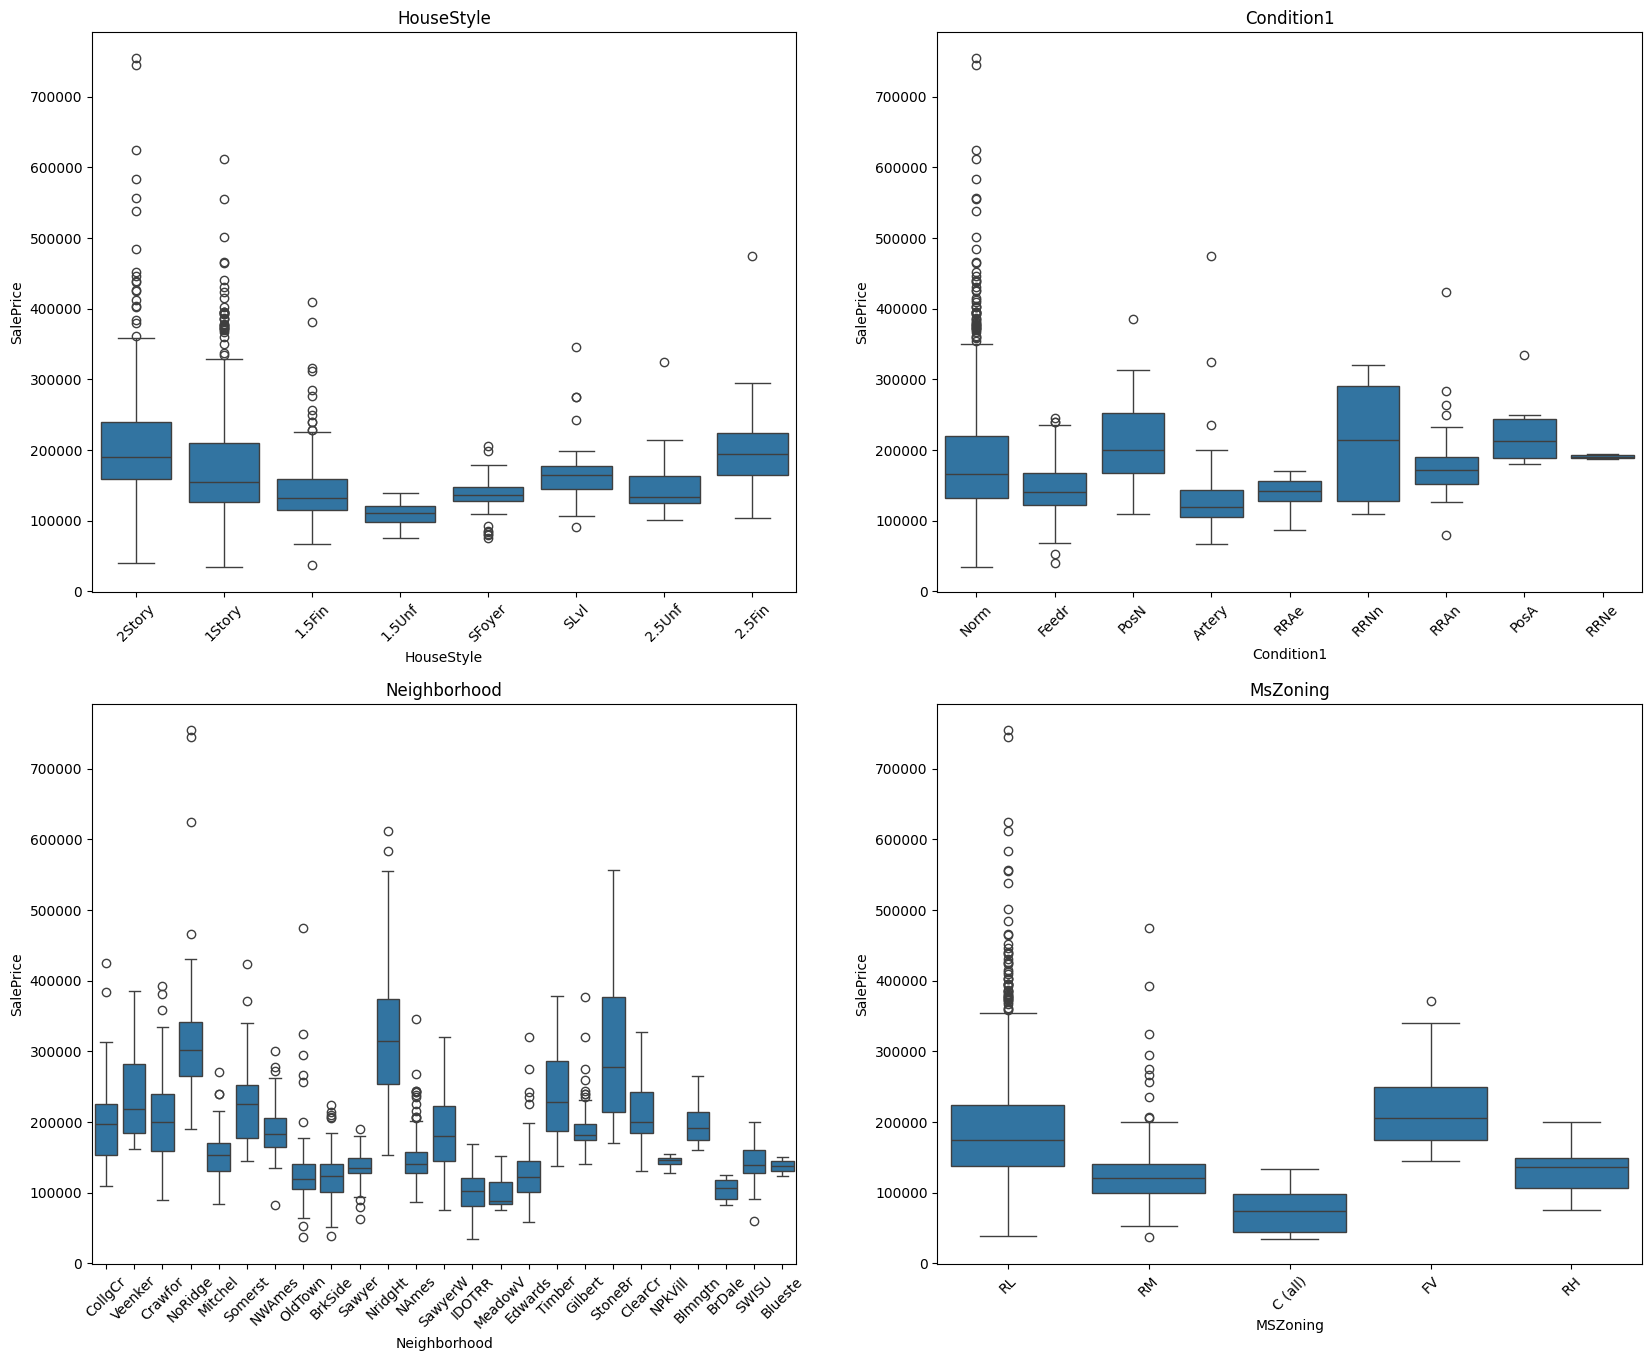

In [16]:
#Analyse der vermütete kategorische Variabeln mit der Hilfe Boxplots.

fig, axes = plt.subplots(2, 2, figsize=(20, 16))

sns.boxplot(x='HouseStyle', y='SalePrice', ax=axes[0, 0], data=train_df_initial)
axes[0, 0].set_title('HouseStyle')
axes[0, 0].tick_params(axis='x', rotation=45)

sns.boxplot(x='Condition1', y='SalePrice', data=train_df_initial, ax=axes[0, 1])
axes[0, 1].set_title('Condition1')
axes[0, 1].tick_params(axis='x', rotation=45)

sns.boxplot(x='Neighborhood', y='SalePrice', ax=axes[1, 0], data=train_df_initial)
axes[1, 0].set_title('Neighborhood')
axes[1, 0].tick_params(axis='x', rotation=45)

sns.boxplot(x='MSZoning', y='SalePrice', data=train_df_initial, ax=axes[1, 1])
axes[1, 1].set_title('MsZoning')
axes[1, 1].tick_params(axis='x', rotation=45)

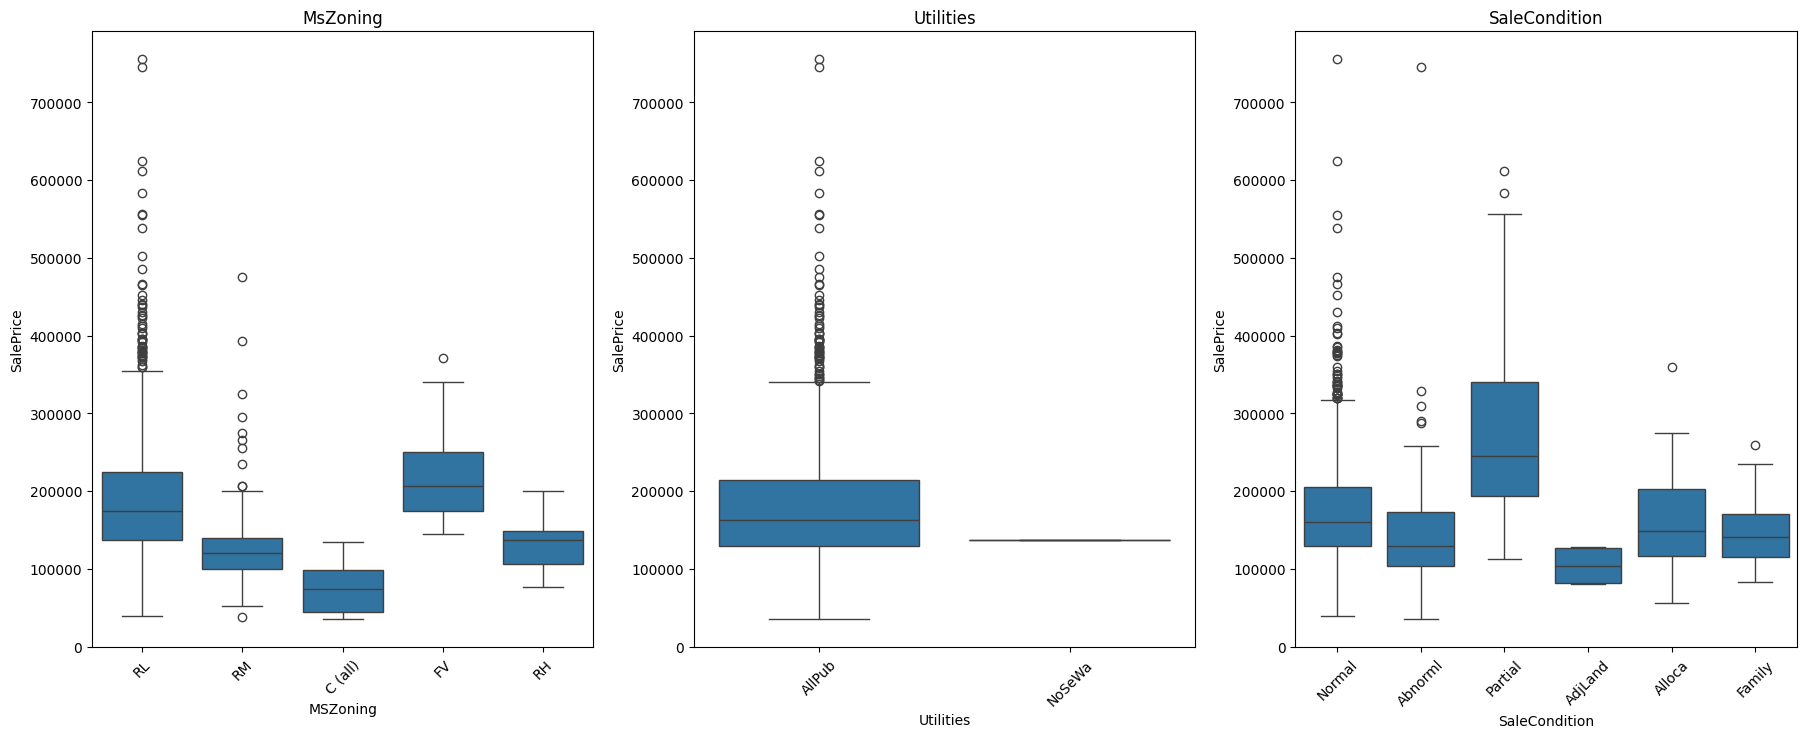

In [21]:
fig, axes = plt.subplots(1, 3, figsize=(22, 8))

sns.boxplot(x='MSZoning', y='SalePrice', data=train_df_initial, ax=axes[0])
axes[0].set_title('MsZoning')
axes[0].tick_params(axis='x', rotation=45)


sns.boxplot(x='Utilities', y='SalePrice', data=train_df_initial, ax=axes[1])
axes[1].set_title('Utilities')
axes[1].tick_params(axis='x', rotation=45)

sns.boxplot(x='SaleCondition', y='SalePrice', data=train_df_initial, ax=axes[2])
axes[2].set_title('SaleCondition')
axes[2].tick_params(axis='x', rotation=45)

In [22]:
# Kategorische Variablen in numerische umwandeln

cat_train_df_encoded = pd.get_dummies(cat_train_df, columns=categorical_rel_features, drop_first=True)

cat_train_df_encoded

,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2.5Fin,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl,Condition1_Feedr,Condition1_Norm,Condition1_PosA,...,Neighborhood_Veenker,MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,False,False,False,False,True,False,False,False,True,False,...,False,False,False,True,False,False,False,False,True,False
1,False,True,False,False,False,False,False,True,False,False,...,True,False,False,True,False,False,False,False,True,False
2,False,False,False,False,True,False,False,False,True,False,...,False,False,False,True,False,False,False,False,True,False
3,False,False,False,False,True,False,False,False,True,False,...,False,False,False,True,False,False,False,False,False,False
4,False,False,False,False,True,False,False,False,True,False,...,False,False,False,True,False,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,False,False,False,False,True,False,False,False,True,False,...,False,False,False,True,False,False,False,False,True,False
1456,False,True,False,False,False,False,False,False,True,False,...,False,False,False,True,False,False,False,False,True,False
1457,False,False,False,False,True,False,False,False,True,False,...,False,False,False,True,False,False,False,False,True,False
1458,False,True,False,False,False,False,False,False,True,False,...,False,False,False,True,False,False,False,False,True,False
